## Recreate DQN model from Deepmind Atari paper

References:   
Paper: https://arxiv.org/pdf/1312.5602.pdf    
Pytorch tutorial: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

### Dependencies
gym==0.21.0     
torch==2.1.0.dev20230526

In [1]:
# import relevant packages
import torch
from collections import namedtuple, deque
import random
from torch import nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import gym
import pandas as pd
import numpy as np
import cv2
import os
from tqdm import tqdm
import gc
from torch.utils.tensorboard import SummaryWriter

### Experience Replay   
Data structure to store past experiences and sample some examples for training, the idea is to ***"alleviate the problems of correlated data and non-stationary distributions"***

In [2]:
# Use named tuple to represent Experience referred in paper
Experience = namedtuple('Experience', ["state", "action", "reward", "successor", "done"])

class ReplayMemory():
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        
    def push(self, *args):
        """add new experience"""
        self.memory.append(Experience(*args))
        
    def sample(self, batch_size):
        """randomly sample experiences from Replay Memory"""
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        """Override default len() method"""
        return len(self.memory)

### Training Model  
Build model based on the paper's description 
> The input to the neural network consists is an 84 × 84 × 4 image produced by φ. The first hidden layer convolves **16 8 × 8 filters with stride 4** with the input image and applies a **rectifier nonlinearity**. The second hidden layer convolves **32 4 × 4 filters with stride 2**, again followed by a **rectifier nonlinearity**. The final hidden layer is fully-connected and consists of **256 rectifier units**. The output layer is a fully- connected linear layer with a **single output for each valid action**.

In [3]:
class DQN_model(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN_model, self).__init__()
        self.layer1 = nn.Conv2d(input_shape[0], 16, kernel_size=(8,8), stride=4)
        self.layer2 = nn.Conv2d(16, 32, (4,4), stride=2)
        # output shape after EACH convo would be ((dimension - filter size)/stride +1) **2 (for 2 sides)
                                                                            # * 4 (stack) * output_channel
        dim_size = (((84-8)/4 + 1)-4)/2+1
        self.layer3 = nn.Linear(int((dim_size)**2 * 32), 256)
        self.output = nn.Linear(256, n_actions) 
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.layer3(x))
        x = self.output(x)
        
        return x

### Prepare environment   
The paper specifies several preprocessing steps to apply to the raw frames
>210 × 160 pixel images with a 128 color palette, can be computationally demanding, so we apply a basic preprocessing step aimed at reducing the input dimensionality. The raw frames are preprocessed by first converting their RGB representation to **gray-scale** and **down-sampling it to a 110×84 image**. The final input representation is obtained by cropping an 84 × 84 region of the image that roughly captures the playing area.

Using gym, we can apply **GrayScaleObservation** wrapper to get gray-scale representation, and instead of cropping to game play section, a **resize wrapper** is applied

<br>

> For the experiments in this paper, the function φ from algorithm 1 applies this preprocessing to the **last 4 frames of a history and stacks them** to produce the input to the Q-function.

For this, we can apply **FrameStack** wrapper to get a stacks of 4 frames

<br>

> Since the scale of scores varies greatly from game to game, we fixed all positive rewards to be 1 and all negative rewards to be −1, leaving 0 rewards unchanged.


Lastly, we can apply **ClipReward** wrapper to crop reward to specified range
<br>

State shape:  (4, 84, 84, 1)
Info  {'lives': 5, 'episode_frame_number': 4, 'frame_number': 4}


A.L.E: Arcade Learning Environment (version 0.7.4+069f8bd)
[Powered by Stella]


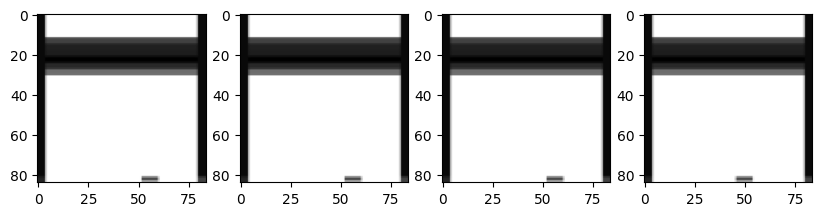

Low value 0.0 - High value 0.5803921818733215


In [4]:
from gym.wrappers import GrayScaleObservation, ResizeObservation, FrameStack, TransformObservation

# Wrapper to clip reward, taken from documentation
class ClipReward(gym.RewardWrapper):
    def __init__(self, env, min_reward, max_reward):
        super().__init__(env)
        self.min_reward = min_reward
        self.max_reward = max_reward
        self.reward_range = (min_reward, max_reward)
    
    def reward(self, reward):
        return np.clip(reward, self.min_reward, self.max_reward)
    
# observation wrapper for cropping
class AtariCropping(gym.ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops image"""
        super().__init__(env)
        
        old_shape = env.observation_space.shape
        # get new shape after cropping
        new_shape = (old_shape[0]-50,) + old_shape[1:]
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=new_shape)

    def observation(self, img):
        """what happens to each observation"""
        # crop image (top and bottom, top from 34, bottom remove last 16)
        img = img[34:-16, :, :]
        return img
    
class RescaleRange(gym.ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that rescale low and high value"""
        super().__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=env.observation_space.shape)

    def observation(self, img):
        """what happens to each observation"""
        # rescale value from range 0-255 to 0-1
        img = img.astype('float32') / 255.   
        return img

def generate_env(env_name):
    env = gym.make(env_name)
    env = ClipReward(env, -1, 1)
    env = AtariCropping(env)
    # gray scale frame
    env = GrayScaleObservation(env, keep_dim=False)
    env = RescaleRange(env)
    # resize frame to 84×84 image
    env = ResizeObservation(env, (84, 84))
    # stack 4 frames (equivalent to what phi does in paper) 
    env = FrameStack(env, num_stack=4)
    
    return env
    
env = generate_env("BreakoutDeterministic-v4")
env.reset()
observation, reward, done, info = env.step(env.action_space.sample())
print("State shape: ", np.asarray(observation).shape)
print("Info ", info)

# visualize frames in each step 
_, axs = plt.subplots(1, 4, figsize=(10,10))
for i, image in enumerate(observation):
    axs[i].imshow(image, cmap=plt.cm.binary)
plt.show()

print(f"Low value {np.min(np.asarray(observation))} - High value {np.max(np.asarray(observation))}")

### Function to determine action
Apply $\epsilon$ greedy algorithm to choose action   
* Choose random action at probability $\epsilon$
* Choose optimal action (determined by model) at probability (1-$\epsilon$)

In [5]:
import random

def choose_action(model, state, device, epsilon=0.001):
    if random.random()<=epsilon: #exploration
        return env.action_space.sample()
    else:
        with torch.no_grad():
    #         squeeze to remove last dim of 1 (for gray scaled val) and add 1 dim at first (1 input instead of batch)
            state = torch.Tensor(state).squeeze().unsqueeze(0).to(device)
            # predict
            pred = model(state)
            action = torch.argmax(pred.squeeze()).item()
            return int(action)

### Loss function  
As mentioned in the paper, the function to optimize would be the following
> $$L_i(θ_i) = E_{s,a∼ρ(·)} [(y_i − Q (s, a; θ_i))]^2 $$
> where: $$y_i = E_{s′∼\mathcal{E}} [r + γ max_{a′} Q(s′, a′; θ_{i−1})|s, a]$$

Notation translation:
- θ refers to weights of model, $θ_i$ refers to model (with weights) at iteration i
- $Q (s, a; θ_i)$ (prediction) is Q value at (s, a) estimated by model
- $y_i$ (target function) is calculated using Bellman equation, but future reward (aka Q(s', a')) is (again) estimated by the model

Code translation:
- $Q (s, a; θ_i)$ is calculated by plug in state for model to predict, and get the output at action a (state and action sampled from experience replay)
- $max_{a′} Q(s′, a′; θ_{i−1}$) in $y_i$ is calculated by plug in successor state, then get the max output out of all actions
- loss is square root of $y_i$ (expected Q) - $Q (s, a; θ_i)$ (prediction)

In [6]:
def loss_fn(model, replay_memory, batch_size, discount, target_model=None, device="mps"):
    batch = replay_memory.sample(batch_size)

#     Transpose batch, ref: https://stackoverflow.com/questions/19339/transpose-unzip-function-inverse-of-zip/19343#19343
    batch = Experience(*zip(*batch))
    
#     convert to a single np.array for faster tensor conversion
    state = np.array(batch.state)
    successor = np.array(batch.successor)
            
    # Tensor-ify state, action, reward, successor, done (use torch tensor to have grad)
    state = torch.Tensor(state).squeeze().to(device)
    action = torch.Tensor(batch.action).to(device)
    reward = torch.Tensor(batch.reward).to(device)
    successor = torch.Tensor(successor).squeeze().to(device)
    done = torch.tensor(batch.done, dtype=torch.int32).to(device)

    # use model to get old qs and successor qs
    old_qs = model(state)
    # if target model is provided -> use that to compute successor instead
    successor_qs = model(successor) if target_model is None else target_model(successor) 
    
#   check for exploding/diminissing problem
#     print(torch.isnan(old_qs).any())
        
    # get the list of actions in shape 1xbatch_size, and use it as indices for old_qs
    action = action.unsqueeze(1).type(torch.int64)
    # get predicted qs at action, return tensor of list of batch_size items
    old_qs = old_qs.gather(1, action).squeeze()
    # get max q in successor to estimate future reward
    successor_qs = successor_qs.max(1)[0]
            
    # compute expected qs
    # multiplying (1-done) would result in not adding future reward when at end state (done==1)
    expected_qs = reward + successor_qs*discount*(1-done)
    expected_qs = expected_qs.detach() # shouldnt include this in grad graph
        
    # compute loss, return mean loss of batch 
    loss = (expected_qs-old_qs).pow(2).mean()
    
#     print("Old Qs ", old_qs)
#     print("Expected Qs ", expected_qs)
#     print("Loss ", loss.item())
    
    # improvement for stability - use different loss 
#     loss_func = nn.HuberLoss()
#     loss = loss_func(old_qs, expected_qs)
    
    return loss

### Evaluation 
Evaluate model by let model plays in the env in 10000 steps, and return **average reward** and **predicted Q** value of a <u>held out set of states</u> 

In [7]:
4def eval_model(model, env_id, eval_steps=10000, device="mps"):
    env=generate_env(env_id)
    curr_state = env.reset()
    curr_state = np.asarray(curr_state)
    
    episode_rewards = [0]
    
    for i in range(eval_steps):
        action = choose_action(model, curr_state, device, epsilon=0.05)
        
        observation, reward, done, _ = env.step(action)
        observation = np.asarray(observation) #convert to np array
        
        episode_rewards[-1]+=reward
        curr_state = observation
        
        if done:
            # end of episode -> reset env, create new total reward for episode
            curr_state = env.reset()
            curr_state = np.asarray(curr_state)
            episode_rewards.append(0)
            
    # calculate mean episode
    episode_reward = np.array(episode_rewards)
    return np.mean(episode_reward)

### Parameters

In [11]:
# ------- Set up parameters -------
ENV = "BreakoutDeterministic-v4"
LOG_FREQ = 20 #number of EPISODES in-between logging results 
EVAL_FREQ = 50000 #number of STEPS before evaluate model
CHECKPOINT_FREQ = 250000 #number of STEPS before saving model
SAVE_DIR = "Breakout_PenalizeLoseLives" #directory to save stuffs

# ------ Hyper parameters ---------
LEARNING_RATE = 0.00001 if ENV == "BreakoutDeterministic-v4" else 0.00025
REPLAY_LEN = 100000 # 1000000 in paper, but I still like mah laptop, so no
BATCH_SIZE = 32
EPISODES = 15000
DISCOUNT = 0.99 #aka gamma in Bellman's equation
START_EPSILON= 1
END_EPSILON= 0.1
DECAY_STEPS=1000000 # steps to decay epsilon
USE_TARGET_MODEL=True # whether to have target model or not
UPDATE_TARGET=1000 #steps to run before updating the target model

### Setting up variables before training

In [12]:
# ------- Set up device, check for mps, cuda or cpu -----------
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# ------- Set up env ----------------
env = generate_env(ENV)
print(f"Current Atari environment: {ENV}")
print(f"Learning rate: {LEARNING_RATE}")

# ------- Set up model ----------------
model = DQN_model(env.observation_space.shape, env.action_space.n).to(device)
target_model = None
if USE_TARGET_MODEL:
    target_model = DQN_model(env.observation_space.shape, env.action_space.n).to(device)
    target_model.load_state_dict(model.state_dict())

# ------- Set up optimizer ----------------
# optimizer based on paper
# optimizer = optim.RMSprop(model.parameters(), lr=LEARNING_RATE)

# optimizer for first training (not-so-happy accident =)))
# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

# recommended (less computational heavy compared to RMSprop)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# ------- Set up stats tracker ----------------
steps = 0 # no steps
highest_reward = 0 # highest evaluation reward
epsilon = 1

# ------- Set up replay buffer ----------------
curr_state = env.reset()
curr_state = np.asarray(curr_state) #convert to np array
replay_memory = ReplayMemory(capacity=REPLAY_LEN)
prev_lives = 0 # keep track of previous life
for i in range(BATCH_SIZE):
    action = env.action_space.sample()
    observation, reward, done, info = env.step(action)
    
    # encode losing life as ending episode to penalize losing life
    terminated = (info['lives'] < prev_lives) or done
    prev_lives = info['lives']
    observation = np.asarray(observation) #convert to np array
    replay_memory.push(curr_state, action, reward, observation, terminated)
    
    # update curr state
    curr_state = observation
    
    if done:
        curr_state = env.reset()
        curr_state = np.asarray(curr_state)
        prev_lives = 0
print(f"Initial length of replay memory: {len(replay_memory)}")

# ------- Set up saving dir ----------------
sub_folders = ["checkpoints", "tensorboard_runs"] # list of subfolders
for sub_folder in sub_folders:
    path = f"{SAVE_DIR}/{sub_folder}/"
    if not os.path.exists(path):
        # Create a new directory because it does not exist
        os.makedirs(path)
        print(f"{path} created")
        
# ------- Set up Tensorboard --------------
sample_input = replay_memory.sample(32)
#     Transpose 
sample_input = Experience(*zip(*sample_input))
#     convert to a single np.array for faster tensor conversion
sample_state = np.array(sample_input.state)
# Tensor-ify state, action, reward, successor, done
sample_state = torch.Tensor(sample_state).squeeze().to(device)

writer = SummaryWriter(log_dir=f"{SAVE_DIR}/tensorboard_runs/")
writer.add_graph(model, sample_state) # add graph for model

print(f'Start Tensorboard by running this command from project folder: tensorboard --logdir="{SAVE_DIR}/tensorboard_runs"')

Device: mps
Current Atari environment: BreakoutDeterministic-v4
Learning rate: 1e-05
Initial length of replay memory: 32
Start Tensorboard by running this command from project folder: tensorboard --logdir="Breakout_PenalizeLoseLives/tensorboard_runs"


### Training process

In [ ]:
with tqdm(total=EPISODES, unit="eps") as pbar:

    # main training loop
    for i in range(EPISODES):
        curr_state = env.reset()
        curr_state = np.asarray(curr_state) #convert to np array
        loss_val = 0 # loss value for curr episode
        reward_val = 0 # reward value for curr episode
        prev_lives = 0
        
        while True:
        # ---------- Epsilon decay logic ------------
            # decay over the first million frames then stay at 0.1
            decay = (DECAY_STEPS - steps)/DECAY_STEPS if steps < DECAY_STEPS else 0
            epsilon = END_EPSILON + decay*(START_EPSILON-END_EPSILON)
            
        # ---------- Training steps logic ------------
            # execute action
            action = choose_action(model, curr_state, device, epsilon=epsilon)
            observation, reward, done, _ = env.step(action)
            observation = np.asarray(observation) #convert to np array
            
            # encode losing life as ending episode to penalize losing life
            terminated = (info['lives'] < prev_lives) or done
            prev_lives = info['lives']
            
            # save observation
            replay_memory.push(curr_state, action, reward, observation, terminated)

            # update curr_state
            curr_state = observation

            # sample and compute loss
            loss = loss_fn(model, replay_memory, BATCH_SIZE, DISCOUNT, target_model=target_model, device=device)
            loss_item = loss.item()
            
            # zero out gradient before backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # ---------- Logging and update various stuffs ------------
            # update target model if available
            if USE_TARGET_MODEL:
                if steps%UPDATE_TARGET:
                    target_model.load_state_dict(model.state_dict())

            # update loss as the max loss during episode
            loss_val = max(loss_item, loss_val)
            # add steps count for epsilon decay
            steps+=1
            # update total reward of episode
            reward_val += reward

            if steps%CHECKPOINT_FREQ==0:
                with open(f"{SAVE_DIR}/checkpoints/{steps}.pt", 'wb') as f:
                    torch.save(model.state_dict(), f)

            if steps%EVAL_FREQ==0:
                pbar.write("------- Evaluating --------")
                # eval steps
                eval_reward = eval_model(model, ENV, eval_steps=10000, device=device)   
#                 eval_rewards.append(eval_reward)
                pbar.write(f"Evaluation reward (average per episode) {eval_reward}")
                pbar.write("---------------------------")
                writer.add_scalar("Eval | Average reward/episode over Steps", eval_reward, steps)
                highest_reward = max(highest_reward, eval_reward)
                
        # ------ Clean up after each 200 step ------
            del loss
            if steps%200==0:
                gc.collect()

            if done: 
                # finish an episode
                break
                
        # ------ Update training episode stats, use tqdm instead of printing -----
        pbar.update(1)
        pbar.set_description(desc=f"Ep:{i+1}|{steps}steps|Loss:{round(loss_val, 4)}|Reward:{reward_val}")
        
        # ------- Log training loss and training episode rewards for tensorboard
        if i%LOG_FREQ==0:
            writer.add_scalar("Train | Loss over Episode", loss_val, i)
            writer.add_scalar("Train | Reward over Episode", reward_val, i)
            
            
print("FINISH TRAINING PROCESS")
print(f"Finish in {steps} steps, Highest eval reward {highest_reward}")

Ep:274|49881steps|Loss:0.1046|Reward:1.0:   2%|▍                         | 274/15000 [08:52<8:28:45,  2.07s/eps]

------- Evaluating --------


Ep:274|49881steps|Loss:0.1046|Reward:1.0:   2%|▍                         | 274/15000 [09:08<8:28:45,  2.07s/eps]

Evaluation reward (average per episode) 0.3888888888888889
---------------------------


Ep:554|99932steps|Loss:0.0788|Reward:0.0:   4%|▉                         | 554/15000 [18:53<8:07:29,  2.02s/eps]

------- Evaluating --------


Ep:554|99932steps|Loss:0.0788|Reward:0.0:   4%|▉                         | 554/15000 [19:08<8:07:29,  2.02s/eps]

Evaluation reward (average per episode) 2.0384615384615383
---------------------------


Ep:825|149984steps|Loss:0.1066|Reward:3.0:   6%|█▍                       | 825/15000 [29:29<9:42:03,  2.46s/eps]

------- Evaluating --------


Ep:825|149984steps|Loss:0.1066|Reward:3.0:   6%|█▍                       | 825/15000 [29:45<9:42:03,  2.46s/eps]

Evaluation reward (average per episode) 4.866666666666666
---------------------------


Ep:1069|199946steps|Loss:0.1386|Reward:4.0:   7%|█▌                    | 1069/15000 [40:19<10:48:10,  2.79s/eps]

------- Evaluating --------


Ep:1069|199946steps|Loss:0.1386|Reward:4.0:   7%|█▌                    | 1069/15000 [40:37<10:48:10,  2.79s/eps]

Evaluation reward (average per episode) 3.0
---------------------------


Ep:1292|249876steps|Loss:0.1521|Reward:1.0:   9%|█▉                     | 1292/15000 [51:15<9:39:54,  2.54s/eps]

------- Evaluating --------


Ep:1292|249876steps|Loss:0.1521|Reward:1.0:   9%|█▉                     | 1292/15000 [51:32<9:39:54,  2.54s/eps]

Evaluation reward (average per episode) 2.875
---------------------------


Ep:1530|299847steps|Loss:0.0835|Reward:1.0:  10%|██▏                  | 1530/15000 [1:02:15<8:29:21,  2.27s/eps]

------- Evaluating --------


Ep:1530|299847steps|Loss:0.0835|Reward:1.0:  10%|██▏                  | 1530/15000 [1:02:31<8:29:21,  2.27s/eps]

Evaluation reward (average per episode) 3.0
---------------------------


Ep:1800|349918steps|Loss:0.0984|Reward:3.0:  12%|██▌                  | 1800/15000 [1:13:12<9:42:18,  2.65s/eps]

------- Evaluating --------


Ep:1800|349918steps|Loss:0.0984|Reward:3.0:  12%|██▌                  | 1800/15000 [1:13:29<9:42:18,  2.65s/eps]

Evaluation reward (average per episode) 0.11392405063291139
---------------------------


Ep:2056|399870steps|Loss:0.0943|Reward:1.0:  14%|██▉                  | 2056/15000 [1:24:14<8:16:44,  2.30s/eps]

------- Evaluating --------


Ep:2056|399870steps|Loss:0.0943|Reward:1.0:  14%|██▉                  | 2056/15000 [1:24:30<8:16:44,  2.30s/eps]

Evaluation reward (average per episode) 1.15625
---------------------------


Ep:2281|449980steps|Loss:0.1266|Reward:5.0:  15%|███                 | 2281/15000 [1:35:01<10:41:52,  3.03s/eps]

------- Evaluating --------


Ep:2281|449980steps|Loss:0.1266|Reward:5.0:  15%|███                 | 2281/15000 [1:35:17<10:41:52,  3.03s/eps]

Evaluation reward (average per episode) 1.3548387096774193
---------------------------


Ep:2496|499806steps|Loss:0.1038|Reward:2.0:  17%|███▍                 | 2496/15000 [1:45:45<9:30:21,  2.74s/eps]

------- Evaluating --------


Ep:2496|499806steps|Loss:0.1038|Reward:2.0:  17%|███▍                 | 2496/15000 [1:46:01<9:30:21,  2.74s/eps]

Evaluation reward (average per episode) 1.4915254237288136
---------------------------


Ep:2695|549870steps|Loss:0.1206|Reward:0.0:  18%|███▌                | 2695/15000 [1:56:32<10:27:11,  3.06s/eps]

------- Evaluating --------


Ep:2695|549870steps|Loss:0.1206|Reward:0.0:  18%|███▌                | 2695/15000 [1:56:48<10:27:11,  3.06s/eps]

Evaluation reward (average per episode) 3.3095238095238093
---------------------------


Ep:2884|599952steps|Loss:0.1302|Reward:3.0:  19%|███▊                | 2884/15000 [2:07:21<12:02:03,  3.58s/eps]

------- Evaluating --------


Ep:2884|599952steps|Loss:0.1302|Reward:3.0:  19%|███▊                | 2884/15000 [2:07:36<12:02:03,  3.58s/eps]

Evaluation reward (average per episode) 3.85
---------------------------


Ep:3056|649858steps|Loss:0.1069|Reward:5.0:  20%|████                | 3056/15000 [2:18:13<11:43:52,  3.54s/eps]

------- Evaluating --------


Ep:3056|649858steps|Loss:0.1069|Reward:5.0:  20%|████                | 3056/15000 [2:18:29<11:43:52,  3.54s/eps]

Evaluation reward (average per episode) 7.16
---------------------------


Ep:3212|699972steps|Loss:0.1493|Reward:6.0:  21%|████▎               | 3212/15000 [2:29:12<13:12:51,  4.04s/eps]

------- Evaluating --------


Ep:3212|699972steps|Loss:0.1493|Reward:6.0:  21%|████▎               | 3212/15000 [2:29:28<13:12:51,  4.04s/eps]

Evaluation reward (average per episode) 4.764705882352941
---------------------------


Ep:3355|749855steps|Loss:0.1373|Reward:6.0:  22%|████▍               | 3355/15000 [2:40:16<16:37:12,  5.14s/eps]

------- Evaluating --------


Ep:3355|749855steps|Loss:0.1373|Reward:6.0:  22%|████▍               | 3355/15000 [2:40:32<16:37:12,  5.14s/eps]

Evaluation reward (average per episode) 6.925925925925926
---------------------------


Ep:3496|799796steps|Loss:0.1831|Reward:9.0:  23%|████▋               | 3496/15000 [2:51:23<15:43:29,  4.92s/eps]

------- Evaluating --------


Ep:3496|799796steps|Loss:0.1831|Reward:9.0:  23%|████▋               | 3496/15000 [2:51:38<15:43:29,  4.92s/eps]

Evaluation reward (average per episode) 5.424242424242424
---------------------------


Ep:3635|849702steps|Loss:0.1784|Reward:10.0:  24%|████▌              | 3635/15000 [3:02:38<19:11:17,  6.08s/eps]

------- Evaluating --------


Ep:3635|849702steps|Loss:0.1784|Reward:10.0:  24%|████▌              | 3635/15000 [3:02:53<19:11:17,  6.08s/eps]

Evaluation reward (average per episode) 9.523809523809524
---------------------------


Ep:3764|899934steps|Loss:0.1194|Reward:4.0:  25%|█████               | 3764/15000 [3:13:57<14:14:46,  4.56s/eps]

------- Evaluating --------


Ep:3764|899934steps|Loss:0.1194|Reward:4.0:  25%|█████               | 3764/15000 [3:14:13<14:14:46,  4.56s/eps]

Evaluation reward (average per episode) 8.458333333333334
---------------------------


Ep:3887|949832steps|Loss:0.1303|Reward:7.0:  26%|█████▏              | 3887/15000 [3:25:26<15:08:23,  4.90s/eps]

------- Evaluating --------


Ep:3887|949832steps|Loss:0.1303|Reward:7.0:  26%|█████▏              | 3887/15000 [3:25:42<15:08:23,  4.90s/eps]

Evaluation reward (average per episode) 8.291666666666666
---------------------------


Ep:3996|999891steps|Loss:0.1454|Reward:6.0:  27%|█████▎              | 3996/15000 [3:37:02<17:11:19,  5.62s/eps]

------- Evaluating --------


Ep:3996|999891steps|Loss:0.1454|Reward:6.0:  27%|█████▎              | 3996/15000 [3:37:18<17:11:19,  5.62s/eps]

Evaluation reward (average per episode) 11.117647058823529
---------------------------


Ep:4104|1049794steps|Loss:0.1281|Reward:12.0:  27%|████▉             | 4104/15000 [3:48:43<19:55:12,  6.58s/eps]

------- Evaluating --------


Ep:4104|1049794steps|Loss:0.1281|Reward:12.0:  27%|████▉             | 4104/15000 [3:48:59<19:55:12,  6.58s/eps]

Evaluation reward (average per episode) 8.26923076923077
---------------------------


Ep:4207|1099588steps|Loss:0.0908|Reward:11.0:  28%|█████             | 4207/15000 [4:00:27<18:56:49,  6.32s/eps]

------- Evaluating --------


Ep:4207|1099588steps|Loss:0.0908|Reward:11.0:  28%|█████             | 4207/15000 [4:00:42<18:56:49,  6.32s/eps]

Evaluation reward (average per episode) 10.473684210526315
---------------------------


Ep:4307|1149726steps|Loss:0.1648|Reward:14.0:  29%|█████▏            | 4307/15000 [4:12:07<20:34:37,  6.93s/eps]

------- Evaluating --------


Ep:4307|1149726steps|Loss:0.1648|Reward:14.0:  29%|█████▏            | 4307/15000 [4:12:23<20:34:37,  6.93s/eps]

Evaluation reward (average per episode) 10.333333333333334
---------------------------


Ep:4409|1199636steps|Loss:0.2145|Reward:13.0:  29%|█████▎            | 4409/15000 [4:23:49<18:32:29,  6.30s/eps]

------- Evaluating --------


Ep:4409|1199636steps|Loss:0.2145|Reward:13.0:  29%|█████▎            | 4409/15000 [4:24:04<18:32:29,  6.30s/eps]

Evaluation reward (average per episode) 9.476190476190476
---------------------------


Ep:4511|1249555steps|Loss:0.1463|Reward:14.0:  30%|█████▍            | 4511/15000 [4:35:22<22:30:49,  7.73s/eps]

------- Evaluating --------


Ep:4511|1249555steps|Loss:0.1463|Reward:14.0:  30%|█████▍            | 4511/15000 [4:35:38<22:30:49,  7.73s/eps]

Evaluation reward (average per episode) 10.80952380952381
---------------------------


Ep:4612|1299988steps|Loss:0.1874|Reward:13.0:  31%|█████▌            | 4612/15000 [4:47:04<20:31:49,  7.11s/eps]

------- Evaluating --------


Ep:4612|1299988steps|Loss:0.1874|Reward:13.0:  31%|█████▌            | 4612/15000 [4:47:20<20:31:49,  7.11s/eps]

Evaluation reward (average per episode) 10.85
---------------------------


Ep:4709|1349744steps|Loss:0.1265|Reward:10.0:  31%|█████▋            | 4709/15000 [4:58:50<21:55:39,  7.67s/eps]

------- Evaluating --------


Ep:4709|1349744steps|Loss:0.1265|Reward:10.0:  31%|█████▋            | 4709/15000 [4:59:06<21:55:39,  7.67s/eps]

Evaluation reward (average per episode) 11.05
---------------------------


Ep:4805|1399837steps|Loss:0.1095|Reward:8.0:  32%|██████             | 4805/15000 [5:10:39<19:55:01,  7.03s/eps]

------- Evaluating --------


Ep:4805|1399837steps|Loss:0.1095|Reward:8.0:  32%|██████             | 4805/15000 [5:10:55<19:55:01,  7.03s/eps]

Evaluation reward (average per episode) 12.8125
---------------------------


Ep:4896|1449664steps|Loss:0.155|Reward:21.0:  33%|██████▏            | 4896/15000 [5:22:28<23:25:19,  8.35s/eps]

------- Evaluating --------


Ep:4896|1449664steps|Loss:0.155|Reward:21.0:  33%|██████▏            | 4896/15000 [5:22:44<23:25:19,  8.35s/eps]

Evaluation reward (average per episode) 10.80952380952381
---------------------------


Ep:4988|1499953steps|Loss:0.1266|Reward:9.0:  33%|██████▎            | 4988/15000 [5:34:19<19:19:28,  6.95s/eps]

------- Evaluating --------


Ep:4988|1499953steps|Loss:0.1266|Reward:9.0:  33%|██████▎            | 4988/15000 [5:34:35<19:19:28,  6.95s/eps]

Evaluation reward (average per episode) 11.789473684210526
---------------------------


Ep:5074|1549789steps|Loss:0.1708|Reward:21.0:  34%|██████            | 5074/15000 [5:46:08<23:29:45,  8.52s/eps]

------- Evaluating --------


Ep:5074|1549789steps|Loss:0.1708|Reward:21.0:  34%|██████            | 5074/15000 [5:46:23<23:29:45,  8.52s/eps]

Evaluation reward (average per episode) 11.3
---------------------------


Ep:5161|1599198steps|Loss:0.1412|Reward:13.0:  34%|██████▏           | 5161/15000 [5:57:57<21:42:53,  7.95s/eps]

------- Evaluating --------


Ep:5162|1600006steps|Loss:0.1264|Reward:20.0:  34%|██████▏           | 5162/15000 [5:58:13<37:32:45, 13.74s/eps]

Evaluation reward (average per episode) 13.588235294117647
---------------------------


Ep:5250|1649416steps|Loss:0.1152|Reward:9.0:  35%|██████▋            | 5250/15000 [6:09:47<21:23:49,  7.90s/eps]

------- Evaluating --------


Ep:5250|1649416steps|Loss:0.1152|Reward:9.0:  35%|██████▋            | 5250/15000 [6:10:03<21:23:49,  7.90s/eps]

Evaluation reward (average per episode) 13.058823529411764
---------------------------


Ep:5333|1699840steps|Loss:0.116|Reward:18.0:  36%|██████▊            | 5333/15000 [6:21:37<24:25:34,  9.10s/eps]

------- Evaluating --------


Ep:5333|1699840steps|Loss:0.116|Reward:18.0:  36%|██████▊            | 5333/15000 [6:21:53<24:25:34,  9.10s/eps]

Evaluation reward (average per episode) 16.133333333333333
---------------------------


Ep:5417|1749945steps|Loss:0.1158|Reward:15.0:  36%|██████▌           | 5417/15000 [6:33:29<22:43:38,  8.54s/eps]

------- Evaluating --------


Ep:5417|1749945steps|Loss:0.1158|Reward:15.0:  36%|██████▌           | 5417/15000 [6:33:45<22:43:38,  8.54s/eps]

Evaluation reward (average per episode) 15.25
---------------------------


Ep:5496|1799639steps|Loss:0.1621|Reward:14.0:  37%|██████▌           | 5496/15000 [6:45:16<22:20:16,  8.46s/eps]

------- Evaluating --------


Ep:5496|1799639steps|Loss:0.1621|Reward:14.0:  37%|██████▌           | 5496/15000 [6:45:32<22:20:16,  8.46s/eps]

Evaluation reward (average per episode) 17.714285714285715
---------------------------


Ep:5576|1849930steps|Loss:0.1421|Reward:20.0:  37%|██████▋           | 5576/15000 [6:57:02<25:39:28,  9.80s/eps]

------- Evaluating --------


Ep:5576|1849930steps|Loss:0.1421|Reward:20.0:  37%|██████▋           | 5576/15000 [6:57:19<25:39:28,  9.80s/eps]

Evaluation reward (average per episode) 13.5
---------------------------


Ep:5652|1899813steps|Loss:0.1182|Reward:18.0:  38%|██████▊           | 5652/15000 [7:08:51<25:47:18,  9.93s/eps]

------- Evaluating --------


Ep:5652|1899813steps|Loss:0.1182|Reward:18.0:  38%|██████▊           | 5652/15000 [7:09:07<25:47:18,  9.93s/eps]

Evaluation reward (average per episode) 15.866666666666667
---------------------------


Ep:5730|1949545steps|Loss:0.1978|Reward:14.0:  38%|██████▉           | 5730/15000 [7:20:38<23:06:13,  8.97s/eps]

------- Evaluating --------


Ep:5730|1949545steps|Loss:0.1978|Reward:14.0:  38%|██████▉           | 5730/15000 [7:20:53<23:06:13,  8.97s/eps]

Evaluation reward (average per episode) 16.285714285714285
---------------------------


Ep:5805|1999754steps|Loss:0.1095|Reward:10.0:  39%|██████▉           | 5805/15000 [7:32:33<21:59:09,  8.61s/eps]

------- Evaluating --------


Ep:5805|1999754steps|Loss:0.1095|Reward:10.0:  39%|██████▉           | 5805/15000 [7:32:49<21:59:09,  8.61s/eps]

Evaluation reward (average per episode) 17.642857142857142
---------------------------


Ep:5879|2049369steps|Loss:0.1487|Reward:16.0:  39%|███████           | 5879/15000 [7:44:29<23:21:43,  9.22s/eps]

------- Evaluating --------


Ep:5879|2049369steps|Loss:0.1487|Reward:16.0:  39%|███████           | 5879/15000 [7:44:45<23:21:43,  9.22s/eps]

Evaluation reward (average per episode) 16.857142857142858
---------------------------


Ep:5954|2099950steps|Loss:0.2281|Reward:17.0:  40%|███████▏          | 5954/15000 [7:56:24<24:03:49,  9.58s/eps]

------- Evaluating --------


Ep:5954|2099950steps|Loss:0.2281|Reward:17.0:  40%|███████▏          | 5954/15000 [7:56:40<24:03:49,  9.58s/eps]

Evaluation reward (average per episode) 16.714285714285715
---------------------------


Ep:6026|2149976steps|Loss:0.1269|Reward:21.0:  40%|███████▏          | 6026/15000 [8:08:18<25:09:56, 10.10s/eps]

------- Evaluating --------


Ep:6026|2149976steps|Loss:0.1269|Reward:21.0:  40%|███████▏          | 6026/15000 [8:08:34<25:09:56, 10.10s/eps]

Evaluation reward (average per episode) 17.785714285714285
---------------------------


Ep:6097|2199635steps|Loss:0.1677|Reward:10.0:  41%|███████▎          | 6097/15000 [8:20:15<24:08:47,  9.76s/eps]

------- Evaluating --------


Ep:6097|2199635steps|Loss:0.1677|Reward:10.0:  41%|███████▎          | 6097/15000 [8:20:31<24:08:47,  9.76s/eps]

Evaluation reward (average per episode) 15.6
---------------------------


Ep:6167|2249890steps|Loss:0.1751|Reward:19.0:  41%|███████▍          | 6167/15000 [8:32:08<24:43:22, 10.08s/eps]

------- Evaluating --------


Ep:6167|2249890steps|Loss:0.1751|Reward:19.0:  41%|███████▍          | 6167/15000 [8:32:24<24:43:22, 10.08s/eps]

Evaluation reward (average per episode) 18.428571428571427
---------------------------


Ep:6204|2278507steps|Loss:0.1076|Reward:13.0:  41%|███████▍          | 6204/15000 [8:39:01<25:27:00, 10.42s/eps]

In [23]:
# close tensorboard if terminate early
writer.close()

### Save model

In [14]:
with open('breakout_wtarget_dqn.pt', 'wb') as f:
    torch.save(model.state_dict(), f)